<div style="max-width:1200px"><img src="../_resources/mgnify_banner.png" width="100%"></div>

<img src="../_resources/mgnify_logo.png" width="200px">

# How to use the “genome search” for MGnify MAGs

**This notebook aims to give an non-exhaustive overview on how to use the genome search API for MGnify MAGs.**

This notebook is divided in 5 sections:
- 1: Libraries needed to run the full notebook
- 2: How to query the `genomes` database from the MGnify API, save and reload the results
- 3: Explore the whole genome dataset
- 4: Graphical representations
- 5: Case study: Find out whether your own MAGs are novel compared to the MGnify catalogues

This is an interactive code notebook (a Jupyter Notebook).
To run this code, click into each cell and press the ▶ button in the top toolbar, or press `shift+enter`.

## Import libraries

Here are imported the necessary python libraries required to run the examples presented in this notebook.

In [1]:
# Connection to MGnify API
from jsonapi_client import Session as APISession
from jsonapi_client import Modifier
import requests

# Dataframes and display
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Data transformation
from functools import reduce

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline 

# Create signature of MAGs for comparison against database
import sourmash
import glob
import time
from pathlib import PurePath as pp
from Bio import SeqIO

# Warning verbosity
import warnings 
warnings.filterwarnings(action="ignore")

## Query the `genomes` database from MGnify API

For the genome dataset, use `genomes` endpoint.   
A complete list of endpoints can be found at https://www.ebi.ac.uk/metagenomics/api/v1/.

In [3]:
endpoint_name = 'genomes'

The function `Modifier` from the `jsonapi_client` module allows us to query for specific values in given fields (e.g.: 'geographic-origin', 'taxon-lineage').    
One way to explore the available fields is to use `requests` to fetch the API endpoint:

In [4]:
r = requests.get(f"https://www.ebi.ac.uk/metagenomics/api/v1/{endpoint_name}")

In [5]:
r.json()['data'][0]

{'type': 'genomes',
 'id': 'MGYG000303671',
 'attributes': {'genome-id': 15495,
  'geographic-origin': 'Asia',
  'geographic-range': [],
  'accession': 'MGYG000303671',
  'ena-genome-accession': None,
  'ena-sample-accession': None,
  'ena-study-accession': 'SRP272619',
  'ncbi-genome-accession': 'GCA_016303265',
  'ncbi-sample-accession': 'SAMN16927400',
  'ncbi-study-accession': None,
  'img-genome-accession': None,
  'patric-genome-accession': None,
  'length': 1584781,
  'num-contigs': 173,
  'n-50': 12841,
  'gc-content': 43.6,
  'type': 'MAG',
  'completeness': 84.08,
  'contamination': 2.71,
  'rna-5s': 0.0,
  'rna-16s': 0.0,
  'rna-23s': 0.0,
  'trnas': 13.0,
  'nc-rnas': 19,
  'num-proteins': 1447,
  'eggnog-coverage': 90.12,
  'ipr-coverage': 88.8,
  'taxon-lineage': 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Monoglobales;f__Monoglobaceae;g__SIG454;s__SIG454 sp016303265',
  'num-genomes-total': 1,
  'pangenome-size': None,
  'pangenome-core-size': None,
  'pangenome-access

### Get information for a specific genus or species

**Examples:**
Search for available ressources for a specific genus or species of interest.  
- *Listeria*
- *Listeria monocytogenes*


The `taxon-lineage` field contains domain, phylum, class, order, family, genus, species, subspecies as `d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria monocytogenes`(example for *Listeria monocytogenes*).   
The filter can use the full lineage `d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria` or only part of it `g__Listeria` or `Listeria`.

#### Set the desired filter(s)

In [7]:
genus_filter = 'Listeria'
species_filter = 'Listeria monocytogenes'

#### Query the database with the 'Listeria' filter and store the results in a Pandas DataFrame.

In [8]:
with APISession("https://www.ebi.ac.uk/metagenomics/api/v1") as mgnify:
    search_filter = Modifier(f"taxon_lineage={genus_filter}")
    resources = map(lambda r: r.json, mgnify.iterate(endpoint_name, filter=search_filter))
    resources_df = pd.json_normalize(resources)

In [9]:
# Display the table containing the results of the query
resources_df

,type,id,attributes.genome-id,attributes.geographic-range,attributes.geographic-origin,attributes.accession,attributes.ncbi-sample-accession,attributes.ncbi-study-accession,attributes.length,attributes.num-contigs,attributes.n-50,attributes.gc-content,attributes.type,attributes.completeness,attributes.contamination,attributes.rna-5s,attributes.rna-16s,attributes.rna-23s,attributes.trnas,attributes.nc-rnas,attributes.num-proteins,attributes.eggnog-coverage,attributes.ipr-coverage,attributes.taxon-lineage,attributes.num-genomes-total,attributes.pangenome-size,attributes.pangenome-core-size,attributes.pangenome-accessory-size,attributes.last-update,attributes.first-created,relationships.catalogue.data.id,relationships.catalogue.data.type,relationships.biome.data.id,relationships.biome.data.type
0,genomes,MGYG000002392,6517,[NA],not provided,MGYG000002392,SAMN09947982,PRJNA486730,2941624,14,443696,37.79,Isolate,99.45,0.00,94.96,99.67,99.83,20.0,105,2895,98.20,92.92,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria monocytogenes,2,2975.0,2760.0,215.0,2021-12-07T19:05:27.619229,2021-12-07T19:05:27.616284,human-gut-v2-0-1,genome-catalogues,root:Host-associated:Human:Digestive system:Large intestine,biomes
1,genomes,MGYG000002325,6025,"[North America, Europe, NA]",North America,MGYG000002325,SAMN07124731,PRJNA167876,3017944,1,3017944,37.96,Isolate,99.45,0.00,94.96,99.67,99.79,20.0,108,2967,97.84,92.25,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria monocytogenes_B,7,3286.0,2650.0,636.0,2021-12-07T18:49:57.209400,2021-12-07T18:49:57.206690,human-gut-v2-0-1,genome-catalogues,root:Host-associated:Human:Digestive system:Large intestine,biomes
2,genomes,MGYG000001395,5358,[],not provided,MGYG000001395,SAMN02299452,PRJNA224116,2890785,45,227246,37.35,Isolate,99.45,0.55,94.96,93.93,99.83,18.0,86,2880,97.15,91.77,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria innocua,1,NaN,NaN,NaN,2021-12-07T18:25:36.389648,2021-12-07T18:25:36.386977,human-gut-v2-0-1,genome-catalogues,root:Host-associated:Human:Digestive system:Large intestine,biomes
3,genomes,MGYG000001298,8569,[Europe],Europe,MGYG000001298,SAMN00001446,PRJNA224116,2589961,6,982217,41.60,Isolate,99.45,0.00,94.96,99.67,99.83,20.0,64,2561,95.28,91.88,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria grayi,2,2552.0,2552.0,0.0,2021-12-07T20:02:11.108760,2021-12-07T20:02:11.105691,human-gut-v2-0-1,genome-catalogues,root:Host-associated:Human:Digestive system:Large intestine,biomes


**Output:** Four entries are obtained for *Listeria* genus. 

#### Query the database with the 'Listeria monocytogenes' filter and store the results in a Pandas DataFrame.

In [8]:
with APISession("https://www.ebi.ac.uk/metagenomics/api/v1") as mgnify:
    search_filter_2 = Modifier(f"taxon_lineage={species_filter}")
    resources_2 = map(lambda r: r.json, mgnify.iterate(endpoint_name, filter=search_filter_2))
    resources_df_2 = pd.json_normalize(resources_2)

In [9]:
# Display the table containing the results of the query
resources_df_2

,type,id,attributes.genome-id,attributes.geographic-origin,attributes.geographic-range,attributes.accession,attributes.ncbi-sample-accession,attributes.ncbi-study-accession,attributes.length,attributes.num-contigs,attributes.n-50,attributes.gc-content,attributes.type,attributes.completeness,attributes.contamination,attributes.rna-5s,attributes.rna-16s,attributes.rna-23s,attributes.trnas,attributes.nc-rnas,attributes.num-proteins,attributes.eggnog-coverage,attributes.ipr-coverage,attributes.taxon-lineage,attributes.num-genomes-total,attributes.pangenome-size,attributes.pangenome-core-size,attributes.pangenome-accessory-size,attributes.last-update,attributes.first-created,relationships.biome.data.id,relationships.biome.data.type,relationships.catalogue.data.id,relationships.catalogue.data.type
0,genomes,MGYG000002392,6517,not provided,[NA],MGYG000002392,SAMN09947982,PRJNA486730,2941624,14,443696,37.79,Isolate,99.45,0.0,94.96,99.67,99.83,20.0,105,2895,98.20,92.92,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria monocytogenes,2,2975,2760,215,2021-12-07T19:05:27.619229,2021-12-07T19:05:27.616284,root:Host-associated:Human:Digestive system:Large intestine,biomes,human-gut-v2-0,genome-catalogues
1,genomes,MGYG000002325,6025,North America,"[North America, Europe, NA]",MGYG000002325,SAMN07124731,PRJNA167876,3017944,1,3017944,37.96,Isolate,99.45,0.0,94.96,99.67,99.79,20.0,108,2967,97.84,92.25,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria monocytogenes_B,7,3286,2650,636,2021-12-07T18:49:57.209400,2021-12-07T18:49:57.206690,root:Host-associated:Human:Digestive system:Large intestine,biomes,human-gut-v2-0,genome-catalogues


**Output:** Two entries are obtained for *Listeria monocytogenes* species. 

### Save the results as parquet.

Pandas allow you to save your query results in multiple formats. (See [Pandas documentation for more options](https://pandas.pydata.org/docs/reference/frame.html).

`parquet` files can be opened with different libraries including (pandas, pyspark, polar...) and has the advantage of being a compressed data format with column types preserved.

*Note: Uncomment the following cell to save your query and replace `'outputs/'` by the`'desired directory/'` to save your data and `'Listeria_ressources'` by the`'name'` you want to give to your file.*

In [16]:
resources_df.to_parquet('Listeria_resources.parquet')

### Load previously saved parquet files

In [17]:
listeria_df = pd.read_parquet('Listeria_resources.parquet')

In [18]:
listeria_df

,type,id,attributes.genome-id,attributes.geographic-range,attributes.geographic-origin,attributes.accession,attributes.ncbi-sample-accession,attributes.ncbi-study-accession,attributes.length,attributes.num-contigs,attributes.n-50,attributes.gc-content,attributes.type,attributes.completeness,attributes.contamination,attributes.rna-5s,attributes.rna-16s,attributes.rna-23s,attributes.trnas,attributes.nc-rnas,attributes.num-proteins,attributes.eggnog-coverage,attributes.ipr-coverage,attributes.taxon-lineage,attributes.num-genomes-total,attributes.pangenome-size,attributes.pangenome-core-size,attributes.pangenome-accessory-size,attributes.last-update,attributes.first-created,relationships.catalogue.data.id,relationships.catalogue.data.type,relationships.biome.data.id,relationships.biome.data.type
0,genomes,MGYG000002392,6517,[NA],not provided,MGYG000002392,SAMN09947982,PRJNA486730,2941624,14,443696,37.79,Isolate,99.45,0.00,94.96,99.67,99.83,20.0,105,2895,98.20,92.92,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria monocytogenes,2,2975.0,2760.0,215.0,2021-12-07T19:05:27.619229,2021-12-07T19:05:27.616284,human-gut-v2-0-1,genome-catalogues,root:Host-associated:Human:Digestive system:Large intestine,biomes
1,genomes,MGYG000002325,6025,"[North America, Europe, NA]",North America,MGYG000002325,SAMN07124731,PRJNA167876,3017944,1,3017944,37.96,Isolate,99.45,0.00,94.96,99.67,99.79,20.0,108,2967,97.84,92.25,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria monocytogenes_B,7,3286.0,2650.0,636.0,2021-12-07T18:49:57.209400,2021-12-07T18:49:57.206690,human-gut-v2-0-1,genome-catalogues,root:Host-associated:Human:Digestive system:Large intestine,biomes
2,genomes,MGYG000001395,5358,[],not provided,MGYG000001395,SAMN02299452,PRJNA224116,2890785,45,227246,37.35,Isolate,99.45,0.55,94.96,93.93,99.83,18.0,86,2880,97.15,91.77,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria innocua,1,NaN,NaN,NaN,2021-12-07T18:25:36.389648,2021-12-07T18:25:36.386977,human-gut-v2-0-1,genome-catalogues,root:Host-associated:Human:Digestive system:Large intestine,biomes
3,genomes,MGYG000001298,8569,[Europe],Europe,MGYG000001298,SAMN00001446,PRJNA224116,2589961,6,982217,41.60,Isolate,99.45,0.00,94.96,99.67,99.83,20.0,64,2561,95.28,91.88,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria grayi,2,2552.0,2552.0,0.0,2021-12-07T20:02:11.108760,2021-12-07T20:02:11.105691,human-gut-v2-0-1,genome-catalogues,root:Host-associated:Human:Digestive system:Large intestine,biomes


**Output:** Display the saved data as a pandas DataFrame.

## Explore the whole `genomes` dataset.

### Query and save the dataset as parquet file

To query the whole dataset, we can use the same method as previously. The only difference is that **no filter** is passed to the query.  

**Warning:** Querying without filter is computationally expensive and will take time.

A pre-fetched copy of the data (as of 8 November 2022) is available in `../example-data/genomes/all_genome_resources.parquet`.

This was fetched using the following code, which you could copy-and-paste into a code cell to re-fetch the latest data:
```python
with APISession("https://www.ebi.ac.uk/metagenomics/api/v1") as mgnify:
    resources_all = map(lambda r: r.json, mgnify.iterate(endpoint_name))
resources_all_df = pd.json_normalize(resources_all)
resources_all_df
resources_all_df.to_parquet('latest_genome_resources.parquet')
```

### Load the dataset file with another python library

Here is an example to show that the saved parquet files can be loaded with different python libraries (some being more suitable for loading and transforming large amount of data). Of course, this file can also be loaded with pandas (see section 1.3.3. of this notebook). 

For this example, we use pyspark. For help, see the documentation: https://spark.apache.org/docs/latest/api/python/.

Pyspark require to start a `SparkSession` before use. A basic example is shown in the section below.

#### Start Spark Session

In [20]:
from pyspark.sql import SparkSession

import pyspark.sql.functions as F

In [21]:
spark = SparkSession.builder.getOrCreate()

JAVA_HOME is not set


RuntimeError: Java gateway process exited before sending its port number

In [19]:
spark

#### Load the data from the parquet file

In [20]:
all_df = spark.read.parquet('./outputs/parquets/all_genome_ressources')

#### Get the shape of the DataFrame

In [21]:
# To get the number of rows
all_df.count()

9421

In [22]:
# To get the number of columns
len(all_df.columns)

37

**Outputs:** The dataframe has 9421 rows and 37 columns.

### Get stats when applicable

In [23]:
all_df.describe().show(truncate=False, vertical=True)

22/11/10 09:37:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------
 summary                             | count                                                                                                                    
 type                                | 9421                                                                                                                     
 id                                  | 9421                                                                                                                     
 attributes.genome-id                | 9421                                                                                                                     
 attributes.geo

**Ouputs:** For example:
- the first record gives the number of non-null values for each column.
- gc-content on the whole dataset is 47.951392633478235 ± 10.364966184467969 % with a min value of 22.94% and a max value of 74.84%

**Warning:** For Spark, pass column name as '`column.name`' is column name contains `'.'` and `' '`.

In [24]:
# To visualise only gc-content:
all_df.select('`attributes.gc-content`').describe().show()

+-------+---------------------+
|summary|attributes.gc-content|
+-------+---------------------+
|  count|                 9421|
|   mean|   47.951392633478235|
| stddev|   10.364966184467969|
|    min|                22.94|
|    max|                74.84|
+-------+---------------------+



### Get the most represented genus in the dataset

In [25]:
all_df.select(f'`attributes.taxon-lineage`').show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------+
|attributes.taxon-lineage                                                                                                             |
+-------------------------------------------------------------------------------------------------------------------------------------+
|d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Veillonellales;f__Megasphaeraceae;g__Anaeroglobus;s__Anaeroglobus micronuciformis    |
|d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella loescheii                  |
|d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus pneumoniae_D           |
|d__Bacteria;p__Patescibacteria;c__Saccharimonadia;o__Saccharimonadales;f__Saccharimonadaceae;g__UMGS1907;s__                         |
|d__Bacteria;p__Firmicutes_C;c__Negativicutes;o_

**Outputs:** Give a sample of `taxon-lineage` present in the dataset. 

In [26]:
all_df.select('`id`').distinct().count()

9421

In [27]:
all_df.select('`attributes.taxon-lineage`').distinct().count()

7352

**Output:** 9421 entries/ids and 7352 unique taxons.

#### Split the taxon-lineage column into 7 columns

In [28]:
features = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']

In [29]:
all_df1 = reduce(lambda df, i: df.withColumn(features[i], F.col('lineage_split')[i]),
                range(len(features)),
                all_df.withColumn('lineage_split', F.split(F.col('`attributes.taxon-lineage`'), ';')),
                )

In [30]:
all_df1.select(features).show(n=5)

+-----------+------------------+------------------+--------------------+--------------------+----------------+--------------------+
|     domain|            phylum|             class|               order|              family|           genus|             species|
+-----------+------------------+------------------+--------------------+--------------------+----------------+--------------------+
|d__Bacteria|   p__Firmicutes_C|  c__Negativicutes|   o__Veillonellales|  f__Megasphaeraceae| g__Anaeroglobus|s__Anaeroglobus m...|
|d__Bacteria|   p__Bacteroidota|    c__Bacteroidia|    o__Bacteroidales|   f__Bacteroidaceae|   g__Prevotella|s__Prevotella loe...|
|d__Bacteria|     p__Firmicutes|        c__Bacilli|  o__Lactobacillales| f__Streptococcaceae|g__Streptococcus|s__Streptococcus ...|
|d__Bacteria|p__Patescibacteria|c__Saccharimonadia|o__Saccharimonadales|f__Saccharimonada...|     g__UMGS1907|                 s__|
|d__Bacteria|   p__Firmicutes_C|  c__Negativicutes|  o__Selenomonadales| f__

**Output:** 7 new columns are created containing each of the features separatly.

#### Query examples on taxon-lineage column

##### To search the most represented taxon:

In [31]:
all_df1.groupby('`attributes.taxon-lineage`').count().filter(F.col('count')>100).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------+-----+
|attributes.taxon-lineage                                                                                     |count|
+-------------------------------------------------------------------------------------------------------------+-----+
|d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;s__|226  |
+-------------------------------------------------------------------------------------------------------------+-----+



**Output:**  *Collinsella* genus with no species annotated is the most represented taxon in the dataset.

##### To search for a particular lineage:

In [32]:
all_df1.filter(F.col('`attributes.taxon-lineage`').startswith('d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella')).count()

584

**Output:** Number of entries for the *Collinsella* genus, across all species.

##### To search for a particular genus:

In [33]:
all_df1.filter(F.col('`attributes.taxon-lineage`').contains('Collinsella')).count()

584

**Output:** Same results as previously is expected.

#### Query examples on newly created columns:

To search for the most or least represented genus, species, ... in this dataset for example. The search is more flexible than for the full taxon.

In [34]:
all_df1.groupby('genus').count().filter(F.col('count')>100).show()

+--------------+-----+
|         genus|count|
+--------------+-----+
| g__Prevotella|  351|
|        g__RC9|  152|
|           g__|  325|
|g__Collinsella|  584|
+--------------+-----+



**Output:** As previously, the genus *Collinsella* is the most represented with 584 entries.  
The advanges of having the taxon splitted in several columns, allow to show that the genus *Prevotella*, RC9 are among the most represented in this dataset. And also that 325 of the taxons in the database don't have a genus.  
The reason why those taxons didn't appear in the query on the `taxon-lineage` column is that the number of different species indexed for each genus compared to the number of hints calculated are proportionaly higher than for *Collinsella* genus.

In [35]:
all_df1.filter(F.col('genus').isin('g__Prevotella', 'g__RC9', 'g__Collinsella')).groupby('genus').agg(F.countDistinct('species')).show()

+--------------+--------------+
|         genus|count(species)|
+--------------+--------------+
| g__Prevotella|           278|
|        g__RC9|           113|
|g__Collinsella|           277|
+--------------+--------------+



In [36]:
print(f'Prevotella: {351/278}')
print(f'RC9: {152/113}')
print(f'Collinsella: {584/277}. ')

Prevotella: 1.2625899280575539
RC9: 1.345132743362832
Collinsella: 2.108303249097473. 


In [37]:
all_df1.filter(F.col('genus')=='g__Collinsella').select('species').distinct().show(truncate=False)

+----------------------------+
|species                     |
+----------------------------+
|s__Collinsella sp900547765  |
|s__Collinsella sp900548935  |
|s__Collinsella aerofaciens_N|
|s__Collinsella sp900754445  |
|s__Collinsella sp900549455  |
|s__Collinsella sp900549715  |
|s__Collinsella sp900541195  |
|s__Collinsella sp003466125  |
|s__Collinsella sp900555765  |
|s__Collinsella sp900547505  |
|s__Collinsella sp900544995  |
|s__Collinsella sp900551555  |
|s__Collinsella sp900556495  |
|s__Collinsella sp900556415  |
|s__Collinsella sp003438495  |
|s__Collinsella sp900554255  |
|s__Collinsella sp900548565  |
|s__Collinsella sp900545615  |
|s__Collinsella sp900553415  |
|s__Collinsella sp900545165  |
+----------------------------+
only showing top 20 rows



**Output:** Show a sample of *Collinsella* species present in the dataset.

## Graphical representation

In this section are examples of graphical representations that migth be obtained from data of this dataset.

In [38]:
all_df1.count()

9421

#### Representation of the bacterial taxon-lineage

Gives an idea of the representation (proportional) of each taxon in the dataset.

List of the features used for the graphical representation: *(see section 1.4.4.1 where the feature variable is defined)*

In [39]:
features 

['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']

In [40]:
all_df1.select([F.count_distinct(x).alias(f'{features[i]}_count') for i, x in enumerate([*features])]).show()

+------------+------------+-----------+-----------+------------+-----------+-------------+
|domain_count|phylum_count|class_count|order_count|family_count|genus_count|species_count|
+------------+------------+-----------+-----------+------------+-----------+-------------+
|           2|          56|        107|        293|         585|       1991|         6263|
+------------+------------+-----------+-----------+------------+-----------+-------------+



**Output:** Count of the distinct values for each categories.

Function used for graphic representation:   
*Note: Colours and node size can be changed in the code below.*

In [41]:
def get_Sankey(df,cat_cols=[],value_cols='', title='Sankey Diagram'):
    # Colors
    colorPalette = ['rgba(31, 119, 180, 0.8)',
     'rgba(255, 127, 14, 0.8)',
     'rgba(44, 160, 44, 0.8)',
     'rgba(214, 39, 40, 0.8)',
     'rgba(148, 103, 189, 0.8)',
     'rgba(140, 86, 75, 0.8)',
     'rgba(227, 119, 194, 0.8)',
     'rgba(127, 127, 127, 0.8)']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
 
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
 
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum

    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
 
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
 
    # creating data for the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
            pad = 15,
            thickness = 20,
            line = dict(
                color = "black",
                width = 0.5
            ),
            label = labelList,
            color = colorList
        ),
        link = dict(
            source = sourceTargetDf['sourceID'],
            target = sourceTargetDf['targetID'],
            value = sourceTargetDf['count']
        )
    )
    
    # override gray link colors with 'source' colors
    opacity = 0.4
    # change 'magenta' to its 'rgba' value to add opacity
    data['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['node']['color']]
    data['link']['color'] = [data['node']['color'][src].replace("0.8", str(opacity))
                                        for src in data['link']['source']]
    
    
    fig = go.Figure(data=[go.Sankey(
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label =  data['node']['label'],
      color =  data['node']['color']
    ),
    # Add links
    link = dict(
      source =  data['link']['source'],
      target =  data['link']['target'],
      value =  data['link']['value'],
      color =  data['link']['color']
    ))])
    
    fig.update_layout(title_text=title, font_size=10)
    
    return fig.show(renderer='iframe')

Taxon-lineage represented in Genomes dataset

In [42]:
# Convert Spark DataFrame to Pandas DataFrame:
pdf = all_df1.select(features).groupby(features).count().toPandas()

In [43]:
# Title and number of displayed features can be modified  
fig = get_Sankey(pdf,cat_cols=features[0:4], value_cols='count', title='Taxon-lineage represented in Genomes dataset')

#### Representation of a sample of the genomes present in the dataset: Example of the order of the Lactobacillales.

In [44]:
pdf_lactobacillales = all_df1.filter(F.col('order')=='o__Lactobacillales').select(features).groupby(features).count().toPandas()

In [45]:
fig_l = get_Sankey(pdf_lactobacillales,cat_cols=features[0:6], value_cols='count',title='Genomes from the Lactobacillales order')

In [46]:
all_df1.filter(F.col('order')=='o__Lactobacillales').select('species').distinct().count()

164

**Output:** 164 distinct species are present in the database for the order of the Lactobacillales.    
There are too numerous to be represented on this graph.

### Information such as genome length or GC-content can also be represented

Representation can be made by family, genus, species... depending on the number of sequence available and on the biological significance.

In [47]:
lactobacillales_df = all_df1.filter(F.col('order')=='o__Lactobacillales').orderBy('family').toPandas()
lactobacillales_count = all_df1.filter(F.col('order')=='o__Lactobacillales').groupby('family').count().orderBy('family').toPandas()

In [48]:
lactobacillales_count

,family,count
0,f__Aerococcaceae,12
1,f__Enterococcaceae,20
2,f__Lactobacillaceae,86
3,f__Listeriaceae,4
4,f__Streptococcaceae,100
5,f__Vagococcaceae,2


Text(0.5, 0.98, 'Number of genomes avalaible, genome length and GC-content of bacteria belonging the Lactobacillales order')

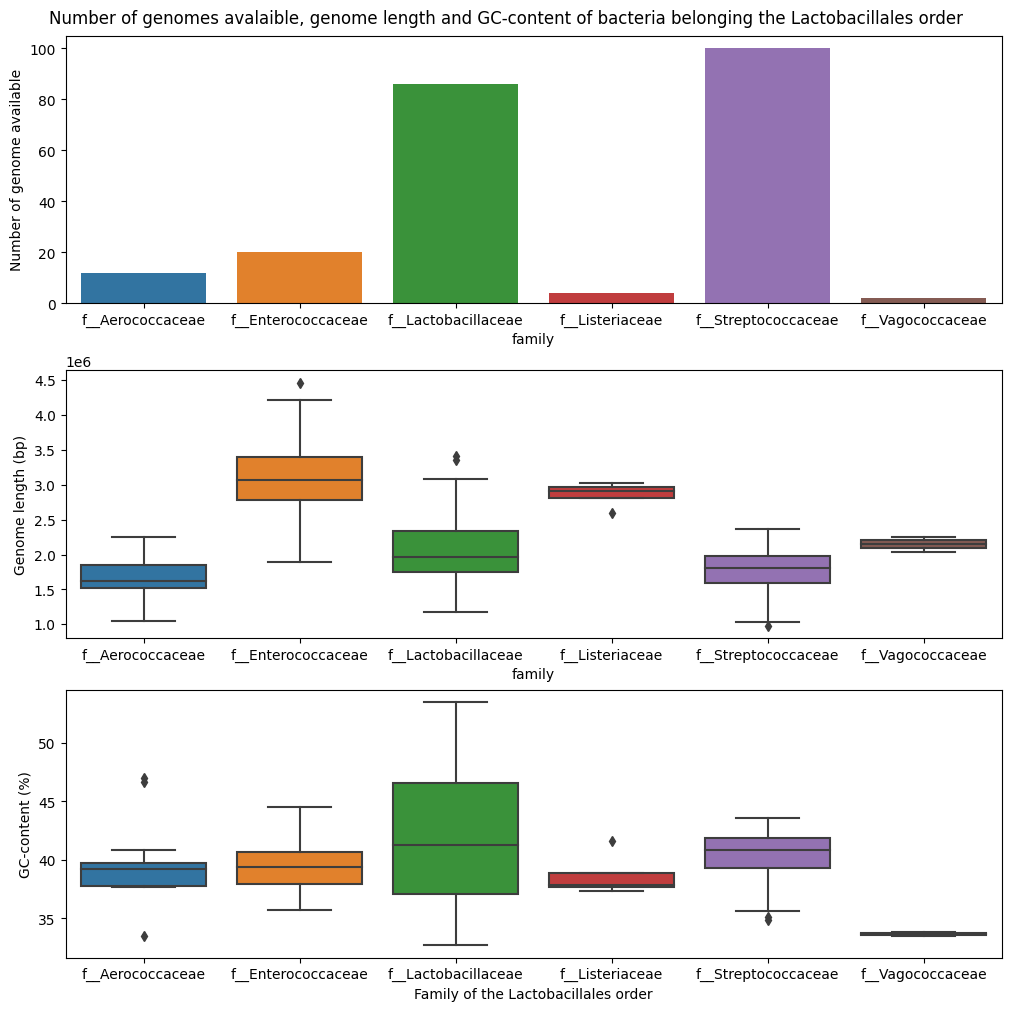

In [49]:
fig = plt.figure(figsize=(10, 10), layout="constrained")
spec = fig.add_gridspec(3, 1)

ax00 = fig.add_subplot(spec[0, 0])
sns.barplot(data=lactobacillales_count, x='family', y='count')
plt.ylabel("Number of genome available")

ax10 = fig.add_subplot(spec[1, 0])
sns.boxplot(data=lactobacillales_df, x='family', y='attributes.length')
plt.ylabel("Genome length (bp)")
#plt.xlabel("Family of the Lactobacillales order")

ax20 = fig.add_subplot(spec[2, 0])
sns.boxplot(data=lactobacillales_df, x='family', y='attributes.gc-content')
plt.ylabel("GC-content (%)")
plt.xlabel("Family of the Lactobacillales order")


fig.suptitle('Number of genomes avalaible, genome length and GC-content of bacteria belonging the Lactobacillales order')
#plt.savefig("outputs/plots/lactobacillales_1.png",transparent=True)

Text(0.5, 0.98, 'Biome and Catalogue related to bacteria belonging the Lactobacillales order')

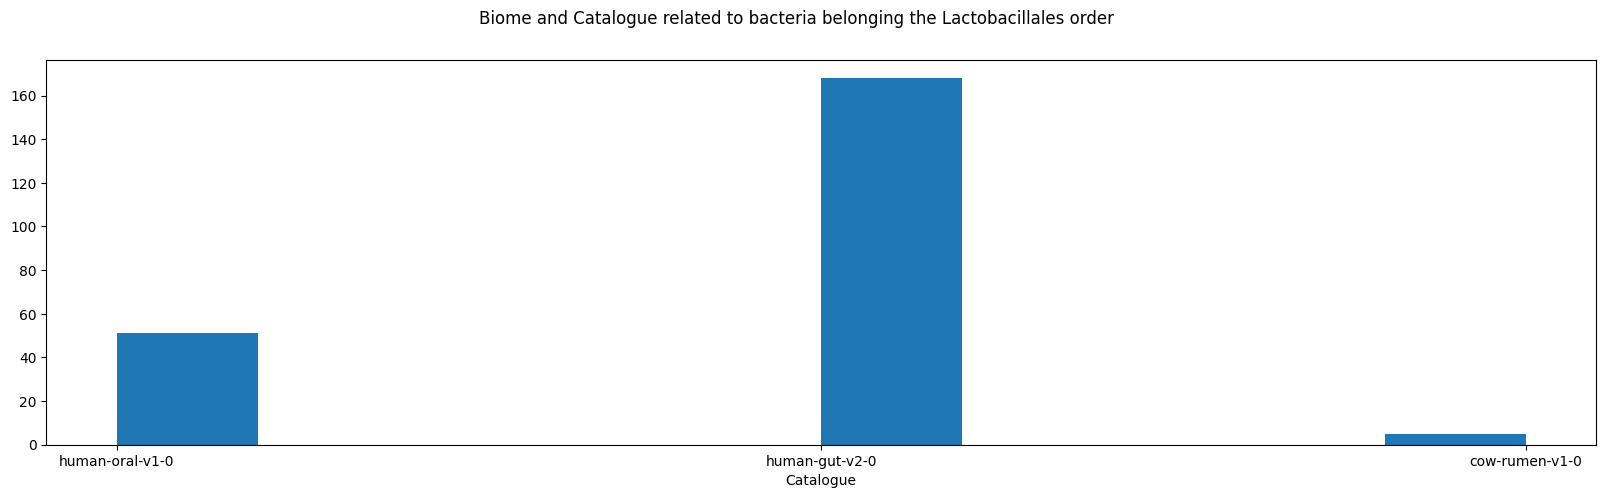

In [50]:
fig = plt.figure(figsize=(20, 5))
spec = fig.add_gridspec(1, 2)

#ax00 = fig.add_subplot(spec[0, 0])
#lactobacillales_df['relationships.biome.data.id'].hist()
#plt.xlabel("Biome")

ax01 = fig.add_subplot(spec[0:])
lactobacillales_df['relationships.catalogue.data.id'].hist()
plt.xlabel("Catalogue")
ax01.grid(False)

fig.suptitle('Biome and Catalogue related to bacteria belonging the Lactobacillales order')
#plt.savefig("outputs/plots/lactobacillales_2.png",transparent=True)

### More example: Produce a similar Figure than Extended Data Fig. 4 a from (https://www.nature.com/articles/s41587-020-0603-3/figures/10)

In [51]:
test_df = all_df1.toPandas()

Statistical informations can be obtained with the `describe` function... (see section 1.4.3)

In [52]:
test_df[['attributes.completeness', 'attributes.contamination']].describe()

,attributes.completeness,attributes.contamination
count,9421.000000,9421.000000
mean,89.622223,1.080019
std,10.601593,1.130176
min,50.060000,0.000000
25%,85.080000,0.030000
50%,93.030000,0.810000
75%,97.630000,1.620000
max,100.000000,5.000000


... and visualised in plots:

Text(0.5, 0.98, 'Quality of genomes avalaible')

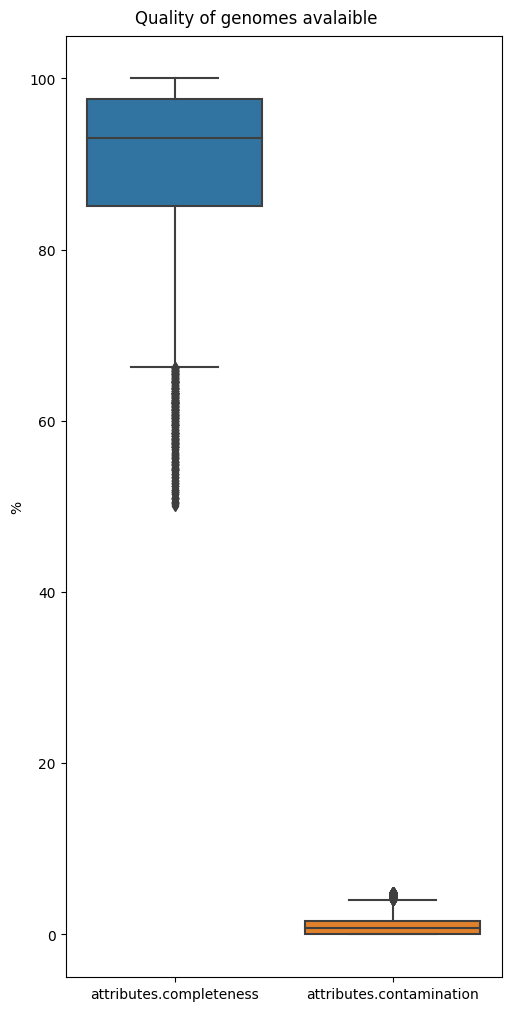

In [53]:
fig = plt.figure(figsize=(5, 10), layout="constrained")
spec = fig.add_gridspec(1, 1)

ax00 = fig.add_subplot(spec[0, 0])
sns.boxplot(data=test_df[['attributes.completeness', 'attributes.contamination']])
plt.ylabel("%")


fig.suptitle('Quality of genomes avalaible')
#plt.savefig("outputs/lactobacillales_1.png",transparent=True)

## Find out whether your own MAGs are novel compared to the MGnify catalogues

Another important use is to query your own MAG against MGnify's MAG catalogues, to see whether they are novel or already represented

### List directories of the files to be analysed:

Replace the str with your own path to folder containing your files. `*` allows to query all the file with the `.fa` extension.

In [54]:
files = glob.glob('inputs/*.fa')

In [55]:
files

['inputs/bin.1.fa',
 'inputs/bin.3.fa',
 'inputs/bin.5.fa',
 'inputs/bin.4.fa',
 'inputs/bin.2.fa']

### Compute a sourmash sketch for each MAG

Create "sketches" for each MAG using Sourmash
(https://sourmash.readthedocs.io/en/latest/index.html#sourmash-in-brief)

A sketch goes into a signature, that we will use for searching. The signature is a sort of collection of hashes that are well suited for calculating the containment of your MAGs within the catalogue's MAGs.

In [56]:
for mag in files:
    # The sourmash parameters are chosen to match those used within MGnify
    sketch = sourmash.MinHash(n=0, ksize=31, scaled=1000)
    
    # A fasta file may have multiple records in it. Add them all to the sourmash signature.
    for index, record in enumerate(SeqIO.parse(mag, 'fasta')):
        sketch.add_sequence(str(record.seq))
        
    # Save the sourmash sketch as a "signature" file
    signature = sourmash.SourmashSignature(sketch, name=record.name)
    with open('outputs/signatures/'+ pp(pp(mag).name).stem + '.sig', 'wt') as fp:
        sourmash.save_signatures([signature], fp)

### Fetch all of the catalogue IDs currently available on MGnify

To fetch the `catalogue IDs` to the MGnify API, use the following endpoint: `https://www.ebi.ac.uk/metagenomics/api/v1/genome-catalogues`.  

In [57]:
catalogue_endpoint = "genome-catalogues"

In [58]:
with APISession("https://www.ebi.ac.uk/metagenomics/api/v1") as mgnify:
    catalogues = map(lambda r: r.json, mgnify.iterate(catalogue_endpoint))
    catalogues = pd.json_normalize(catalogues)

In [59]:
catalogue_ids = list(catalogues['id'])
catalogue_ids

['cow-rumen-v1-0', 'human-gut-v2-0', 'human-oral-v1-0', 'marine-v1-0']

### Submit a search job to the MGnify API

To`submit a job` to the MGnify API, use the following endpoint: `https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/gather`.  
Data will be send to the API, which is called "POST"ing data in the API world.  
This part of the API is quite specialized and so is not a formal JSON:API, the `requests` Python packageìs therefore used to communicate with it.

In [60]:
endpoint = 'https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/gather'

In [61]:
# Create a list of file uploads, and attach them to the API request
signatures = [open(sig, 'rb') for sig in glob.glob('outputs/signatures/*.sig')]
sketch_uploads = [('file_uploaded', signature) for signature in signatures]

# Send the API request - it specifies which catalogue to search against and attaches all of the signature files.
submitted_job = requests.post(endpoint, data={'mag_catalogues': catalogue_ids}, files=sketch_uploads).json()


map(lambda fp: fp.close(), signatures)  # tidy up open file pointers

print(submitted_job)

{'data': {'message': 'Your files bin.4.sig,bin.1.sig,bin.5.sig,bin.3.sig,bin.2.sig were successfully uploaded. Use the given URL to check the status of the new job', 'job_id': 'fc655e22-176a-480a-8b38-29f60db5b896', 'children_ids': None, 'signatures_received': ['bin.4.sig', 'bin.1.sig', 'bin.5.sig', 'bin.3.sig', 'bin.2.sig'], 'status_URL': 'https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/status/fc655e22-176a-480a-8b38-29f60db5b896'}}


### Wait for the results to be ready

As you can see in the `printed submitted_job` above, a status_URL was returned in the response from submitting the job via the API. Since the job is in a queue, this status_URL must be polled to wait for our job to be completed.  
Below is an example to check every 2 seconds until ALL of the jobs are finished. The time can be easily change (to 10s in the example below) by setting a different sleeping value:
```python
time.sleep(10)
```

In [62]:
job_done = False
while not job_done:
    print('Checking status...')
    # The status_URL is another API endpoint that's unique for the submitted search job
    query_result = None
    
    while not query_result:
        query_result = requests.get(submitted_job['data']['status_URL'])
        print('Still waiting for jobs to complete. Current status of jobs')
        print('Will check again in 2 seconds')
        time.sleep(2) 
        
    queries_status = {sig['job_id']: sig['status'] for sig in query_result.json()['data']['signatures']}
    job_done = all(map(lambda q: q == 'SUCCESS', queries_status.values()))
    
print('Job done!')

Checking status...
Still waiting for jobs to complete. Current status of jobs
Will check again in 2 seconds
Still waiting for jobs to complete. Current status of jobs
Will check again in 2 seconds
Job done!


The `query_result` contains the results of the query.   
The results can be visualised as json:

In [63]:
query_result.json()

{'data': {'group_id': 'fc655e22-176a-480a-8b38-29f60db5b896',
  'signatures': [{'job_id': '76b553fe-9463-4bb2-87a8-027a84849b24',
    'status': 'SUCCESS',
    'filename': 'bin.4.sig',
    'result': {'status': 'NO_RESULTS',
     'catalog': 'marine-v1-0',
     'query_filename': 'bin.4.sig',
     'md5_name': '95935c5aa1283dd063a19eff883ea84c.sig'},
    'results_url': 'https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/76b553fe-9463-4bb2-87a8-027a84849b24',
    'catalogue': 'marine-v1-0'},
   {'job_id': '1d3b9270-414d-4e0a-ae11-44fb2daf433c',
    'status': 'SUCCESS',
    'filename': 'bin.4.sig',
    'result': {'status': 'NO_RESULTS',
     'catalog': 'cow-rumen-v1-0',
     'query_filename': 'bin.4.sig',
     'md5_name': '95935c5aa1283dd063a19eff883ea84c.sig'},
    'results_url': 'https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/1d3b9270-414d-4e0a-ae11-44fb2daf433c',
    'catalogue': 'cow-rumen-v1-0'},
   {'job_id': 'a7382137-af64-43e2-b302-2e61fa7822a1',
    's

Or in a DataFrame:

In [64]:
query_result_df = pd.json_normalize(query_result.json()['data']['signatures'])

In [65]:
query_result_df

,job_id,status,filename,results_url,catalogue,result.status,result.catalog,result.query_filename,result.md5_name,result.overlap,result.p_query,result.p_match,result.match,result.matches
0,76b553fe-9463-4bb2-87a8-027a84849b24,SUCCESS,bin.4.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/76b553fe-9463-4bb2-87a8-027a84849b24,marine-v1-0,NO_RESULTS,marine-v1-0,bin.4.sig,95935c5aa1283dd063a19eff883ea84c.sig,NaN,NaN,NaN,NaN,NaN
1,1d3b9270-414d-4e0a-ae11-44fb2daf433c,SUCCESS,bin.4.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/1d3b9270-414d-4e0a-ae11-44fb2daf433c,cow-rumen-v1-0,NO_RESULTS,cow-rumen-v1-0,bin.4.sig,95935c5aa1283dd063a19eff883ea84c.sig,NaN,NaN,NaN,NaN,NaN
2,a7382137-af64-43e2-b302-2e61fa7822a1,SUCCESS,bin.4.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/a7382137-af64-43e2-b302-2e61fa7822a1,human-gut-v2-0,NaN,human-gut-v2-0,bin.4.sig,95935c5aa1283dd063a19eff883ea84c.sig,0.9 Mbp,66.8%,45.4%,MGYG000002570,1.0
3,a2aa6603-7cb7-463b-89dc-1deb8460d554,SUCCESS,bin.4.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/a2aa6603-7cb7-463b-89dc-1deb8460d554,human-oral-v1-0,NO_RESULTS,human-oral-v1-0,bin.4.sig,95935c5aa1283dd063a19eff883ea84c.sig,NaN,NaN,NaN,NaN,NaN
4,36ffae11-c56a-40c8-af55-74f1c1ebd575,SUCCESS,bin.1.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/36ffae11-c56a-40c8-af55-74f1c1ebd575,marine-v1-0,NO_RESULTS,marine-v1-0,bin.1.sig,90de13310088a31d1ccb76f1da574cb6.sig,NaN,NaN,NaN,NaN,NaN
5,ba04545d-5bfb-471d-97ff-c1d96fe36af0,SUCCESS,bin.1.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/ba04545d-5bfb-471d-97ff-c1d96fe36af0,cow-rumen-v1-0,NO_RESULTS,cow-rumen-v1-0,bin.1.sig,90de13310088a31d1ccb76f1da574cb6.sig,NaN,NaN,NaN,NaN,NaN
6,14b0a47d-6a88-43ab-83c9-b661765d6cd1,SUCCESS,bin.1.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/14b0a47d-6a88-43ab-83c9-b661765d6cd1,human-gut-v2-0,NaN,human-gut-v2-0,bin.1.sig,90de13310088a31d1ccb76f1da574cb6.sig,1.9 Mbp,58.9%,52.7%,MGYG000000217,3.0
7,d1776b48-7d34-4436-9dd6-c37119b70096,SUCCESS,bin.1.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/d1776b48-7d34-4436-9dd6-c37119b70096,human-oral-v1-0,NO_RESULTS,human-oral-v1-0,bin.1.sig,90de13310088a31d1ccb76f1da574cb6.sig,NaN,NaN,NaN,NaN,NaN
8,39e4ca1f-28b2-412c-b8ec-5d9dc0aa771b,SUCCESS,bin.5.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/39e4ca1f-28b2-412c-b8ec-5d9dc0aa771b,marine-v1-0,NO_RESULTS,marine-v1-0,bin.5.sig,588a9cfc6aad0f88443f6afd115a738e.sig,NaN,NaN,NaN,NaN,NaN
9,6adfa89a-6ca7-494a-8115-29e96ca6c238,SUCCESS,bin.5.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/6adfa89a-6ca7-494a-8115-29e96ca6c238,cow-rumen-v1-0,NO_RESULTS,cow-rumen-v1-0,bin.5.sig,588a9cfc6aad0f88443f6afd115a738e.sig,NaN,NaN,NaN,NaN,NaN


**Output:** Each signature is queried against each catalogue entry.  
Results can then be analysed according to your research:
- study related to bacteria of the human gut,
- ...

#### Are any of our MAGs found in biomes other than the human gut?

In [66]:
matches = query_result_df.dropna(subset=['result.match'])

In [67]:
matches

,job_id,status,filename,results_url,catalogue,result.status,result.catalog,result.query_filename,result.md5_name,result.overlap,result.p_query,result.p_match,result.match,result.matches
2,a7382137-af64-43e2-b302-2e61fa7822a1,SUCCESS,bin.4.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/a7382137-af64-43e2-b302-2e61fa7822a1,human-gut-v2-0,NaN,human-gut-v2-0,bin.4.sig,95935c5aa1283dd063a19eff883ea84c.sig,0.9 Mbp,66.8%,45.4%,MGYG000002570,1.0
6,14b0a47d-6a88-43ab-83c9-b661765d6cd1,SUCCESS,bin.1.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/14b0a47d-6a88-43ab-83c9-b661765d6cd1,human-gut-v2-0,NaN,human-gut-v2-0,bin.1.sig,90de13310088a31d1ccb76f1da574cb6.sig,1.9 Mbp,58.9%,52.7%,MGYG000000217,3.0
10,18d07061-76da-433a-aba5-a0cc53ca9c18,SUCCESS,bin.5.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/18d07061-76da-433a-aba5-a0cc53ca9c18,human-gut-v2-0,NaN,human-gut-v2-0,bin.5.sig,588a9cfc6aad0f88443f6afd115a738e.sig,0.9 Mbp,49.9%,48.0%,MGYG000004533,1.0
13,5596a219-7fb2-4d62-8765-687b94618200,SUCCESS,bin.3.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/5596a219-7fb2-4d62-8765-687b94618200,cow-rumen-v1-0,NaN,cow-rumen-v1-0,bin.3.sig,c399bb823a0358c2951ad2ac951daef6.sig,0.8 Mbp,30.3%,31.3%,MGYG000292488,1.0
14,3930defe-b858-47c9-ad79-18c6ea185395,SUCCESS,bin.3.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/3930defe-b858-47c9-ad79-18c6ea185395,human-gut-v2-0,NaN,human-gut-v2-0,bin.3.sig,c399bb823a0358c2951ad2ac951daef6.sig,1.8 Mbp,66.8%,57.0%,MGYG000000060,2.0
18,37572925-2cec-482c-8cd3-712125b4f8b3,SUCCESS,bin.2.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/37572925-2cec-482c-8cd3-712125b4f8b3,human-gut-v2-0,NaN,human-gut-v2-0,bin.2.sig,a6546452612d9462460ebdbd94c6c611.sig,3.4 Mbp,22.2%,63.0%,MGYG000002478,19.0


**Output:** DataFrame containing only the results with a positive match in the catalogue.

Text(0.5, 0.98, 'Biomes matched by the MAGs')

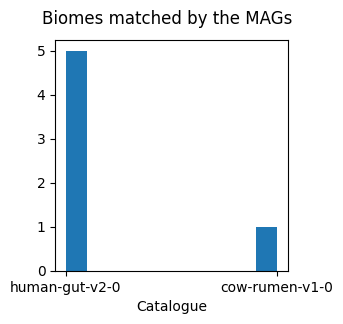

In [68]:
fig = plt.figure(figsize=(3, 3))
spec = fig.add_gridspec(1, 2)

ax01 = fig.add_subplot(spec[0:])
matches.catalogue.hist()
plt.xlabel("Catalogue")
ax01.grid(False)

fig.suptitle('Biomes matched by the MAGs')
#plt.savefig("outputs/signature_matches.png",transparent=True)

**Output:** Display which biomes that were matched during the search by the MAGs. The five signatures match the `human-gut-v2-0` biome and one of the signature also matches the `cow-rumen-v1-0` biome.

#### What is the taxonomy of the MGnify MAGs which match the query?

Call the API for each Genome, to find it's taxonomic lineage.

In [69]:
def get_taxonomy_of_mgnify_mag(match_row):
    mgyg_accession = match_row['result.match']
    with APISession("https://www.ebi.ac.uk/metagenomics/api/v1") as mgnify:
        genome_document = mgnify.get('genomes', mgyg_accession)
        return genome_document.resource.taxon_lineage

Create a new column in the matches the table.

In [70]:
matches['best_match_taxonomy'] = matches.apply(get_taxonomy_of_mgnify_mag, axis=1)

In [71]:
matches

,job_id,status,filename,results_url,catalogue,result.status,result.catalog,result.query_filename,result.md5_name,result.overlap,result.p_query,result.p_match,result.match,result.matches,best_match_taxonomy
2,a7382137-af64-43e2-b302-2e61fa7822a1,SUCCESS,bin.4.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/a7382137-af64-43e2-b302-2e61fa7822a1,human-gut-v2-0,NaN,human-gut-v2-0,bin.4.sig,95935c5aa1283dd063a19eff883ea84c.sig,0.9 Mbp,66.8%,45.4%,MGYG000002570,1.0,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Acutalibacteraceae;g__Ruminococcus_E;s__Ruminococcus_E sp003526955
6,14b0a47d-6a88-43ab-83c9-b661765d6cd1,SUCCESS,bin.1.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/14b0a47d-6a88-43ab-83c9-b661765d6cd1,human-gut-v2-0,NaN,human-gut-v2-0,bin.1.sig,90de13310088a31d1ccb76f1da574cb6.sig,1.9 Mbp,58.9%,52.7%,MGYG000000217,3.0,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Acetatifactor;s__Acetatifactor sp900066565
10,18d07061-76da-433a-aba5-a0cc53ca9c18,SUCCESS,bin.5.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/18d07061-76da-433a-aba5-a0cc53ca9c18,human-gut-v2-0,NaN,human-gut-v2-0,bin.5.sig,588a9cfc6aad0f88443f6afd115a738e.sig,0.9 Mbp,49.9%,48.0%,MGYG000004533,1.0,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__RF32;f__CAG-239;g__CAG-495;s__CAG-495 sp000436375
13,5596a219-7fb2-4d62-8765-687b94618200,SUCCESS,bin.3.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/5596a219-7fb2-4d62-8765-687b94618200,cow-rumen-v1-0,NaN,cow-rumen-v1-0,bin.3.sig,c399bb823a0358c2951ad2ac951daef6.sig,0.8 Mbp,30.3%,31.3%,MGYG000292488,1.0,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospira;s__Lachnospira sp003537285
14,3930defe-b858-47c9-ad79-18c6ea185395,SUCCESS,bin.3.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/3930defe-b858-47c9-ad79-18c6ea185395,human-gut-v2-0,NaN,human-gut-v2-0,bin.3.sig,c399bb823a0358c2951ad2ac951daef6.sig,1.8 Mbp,66.8%,57.0%,MGYG000000060,2.0,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospira;s__Lachnospira eligens_A
18,37572925-2cec-482c-8cd3-712125b4f8b3,SUCCESS,bin.2.sig,https://www.ebi.ac.uk/metagenomics/api/v1/genomes-search/results/37572925-2cec-482c-8cd3-712125b4f8b3,human-gut-v2-0,NaN,human-gut-v2-0,bin.2.sig,a6546452612d9462460ebdbd94c6c611.sig,3.4 Mbp,22.2%,63.0%,MGYG000002478,19.0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Phocaeicola;s__Phocaeicola dorei


**Output:** The `matches` DataFrame has a new column that contains the corresponding `taxon-lineage` information.

Summarise results with more verbose:

In [72]:
for row, match in matches.iterrows():
    print(f"The MAG ({match['filename']}) matches {match['result.match']} which has taxonomy {match['best_match_taxonomy']}")

The MAG (bin.4.sig) matches MGYG000002570 which has taxonomy d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Acutalibacteraceae;g__Ruminococcus_E;s__Ruminococcus_E sp003526955
The MAG (bin.1.sig) matches MGYG000000217 which has taxonomy d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Acetatifactor;s__Acetatifactor sp900066565
The MAG (bin.5.sig) matches MGYG000004533 which has taxonomy d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__RF32;f__CAG-239;g__CAG-495;s__CAG-495 sp000436375
The MAG (bin.3.sig) matches MGYG000292488 which has taxonomy d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospira;s__Lachnospira sp003537285
The MAG (bin.3.sig) matches MGYG000000060 which has taxonomy d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospira;s__Lachnospira eligens_A
The MAG (bin.2.sig) matches MGYG000002478 which has taxonomy d__Bacteria;p__Bacteroidota;c__B

#### Which of our MAGs are completely novel (i.e. in no MGnify catalogue)

One way to check this is to group all of the search results by filename (i.e. finding the queries for each MAG vs all catalogues) and checking whether the sum of all matches is 0...

In [73]:
query_result_df.groupby('filename').apply(lambda query: query['result.matches'].sum() == 0)

filename
bin.1.sig    False
bin.2.sig    False
bin.3.sig    False
bin.4.sig    False
bin.5.sig    False
dtype: bool